<font size="15">Group Project<font>
- Jashan Bains (47733738)
- Priyansh Bahri (89605810)
- Nora Zhou (14167290)
- 

<font size= "5">Introduction:<font>

Understanding player behavior in online games is crucial for optimizing engagement strategies and improving data collection for research and development. In many online gaming environments, players generate vast amounts of behavioral data through their in-game activities, including playtime, subscriptions, and interactions with game features. Identifying which types of players are most likely to contribute a significant amount of data can help game developers and researchers target specific groups for recruitment, improving data collection efficiency.

In this project, we aim to answer the question: "Can we predict a player's type based on their in-game behavior, such as time spent playing and newsletter subscription?" By exploring this question, we hope to identify characteristics of players who contribute the most data, allowing for more effective recruitment strategies.

To answer the question, `players.csv` dataset was used. In general, there are 196 observations in this dataset, the number of variables are 7, including `experience`, `subscribe`, `hashedEmail`, `played_hours`, `name`, `gender` and `Age`. 

-	`experience` : the level of experience of the player (e.g., Pro, Veteran, Regular, Amateur). (Type: character)
-	`subscribe` : whether the player is a subscriber (True/False). (Type: logical)
-	`hashedEmail` : hashed version of the player's email. (Type: character)
-	`played_hours` : number of hours the player has spent playing. (Type: double - numeric values with decimal points) 
-	`name`: player's name (Type: character)
-	`gender` : player's gender (Male, Female, etc.) (Type: character)
-	`Age` : player's age (Type: double)

<font size= "5">Methods and Results:<font>

<font size= "3.5">Description<font>

here

In [1]:
# loading in the needed libraries
library(tidyverse)
library(readr)
library(ggplot2)
library(dplyr)
library(tidyr)
library(lubridate)
library(repr)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [18]:
# loading in the raw data
players_data <- read_csv ("https://raw.githubusercontent.com/jashanbains-24/DSCI-100-Group-Project/refs/heads/main/players.csv")
sessions_data <- read_csv("https://raw.githubusercontent.com/jashanbains-24/DSCI-100-Group-Project/refs/heads/main/sessions.csv")

# cleaning and wrangling data
minecraft_data <- players_data |>
                  select(experience, subscribe, played_hours, gender, Age)|>
                  drop_na(Age)|>
                  drop_na(played_hours)|>
                  drop_na(subscribe)



Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [19]:
# average playtime and age
playtime_mean <-  minecraft_data|>
                    summarize(average_total_playtime=mean(played_hours,na.rm=TRUE),
                             average_total_age=mean(Age, na.rm=TRUE))

playtime_mean

average_total_playtime,average_total_age
<dbl>,<dbl>
5.904639,20.52062


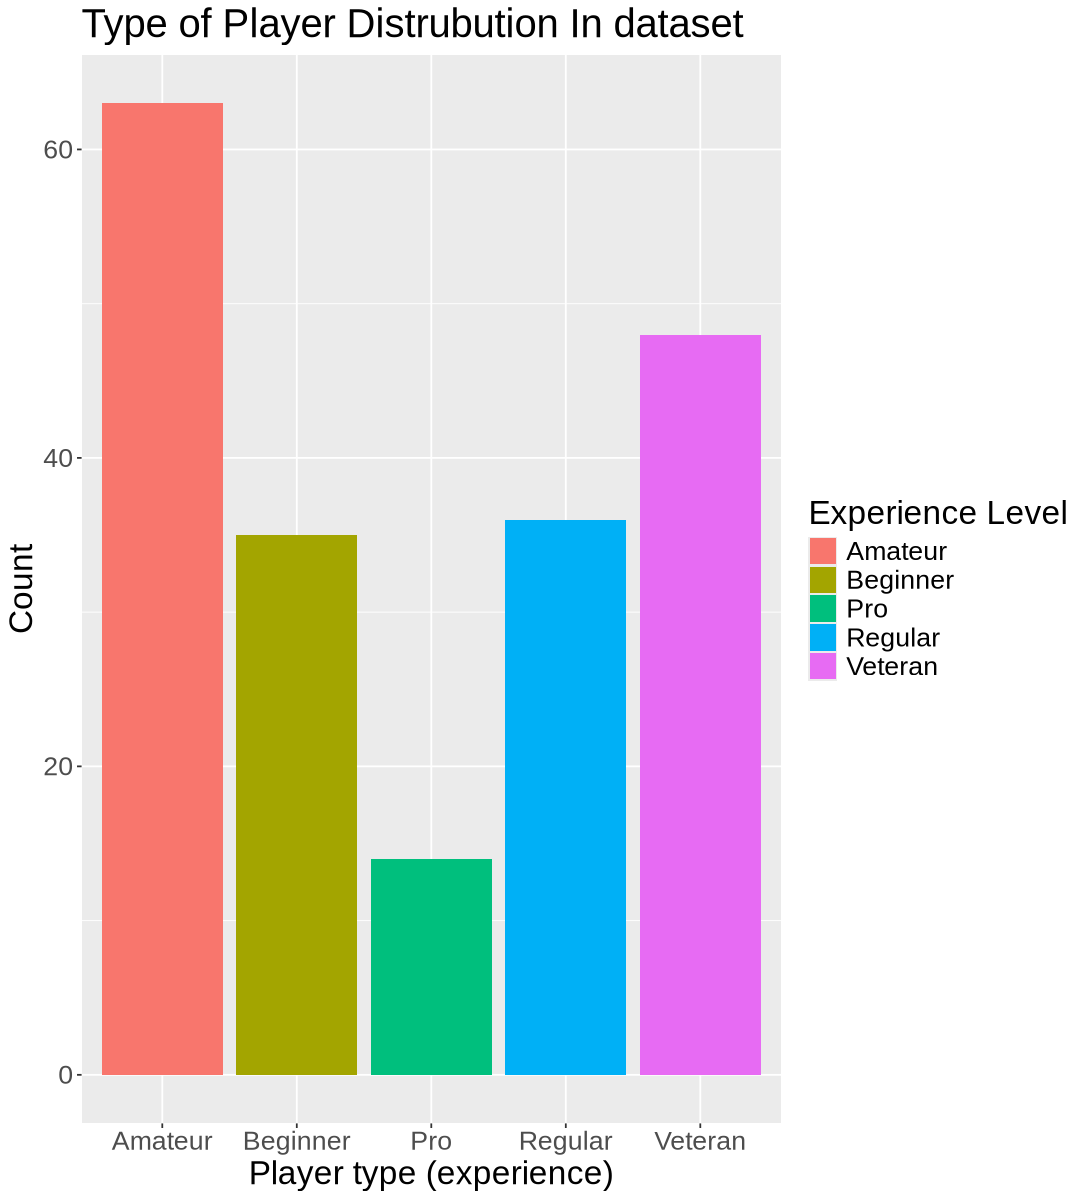

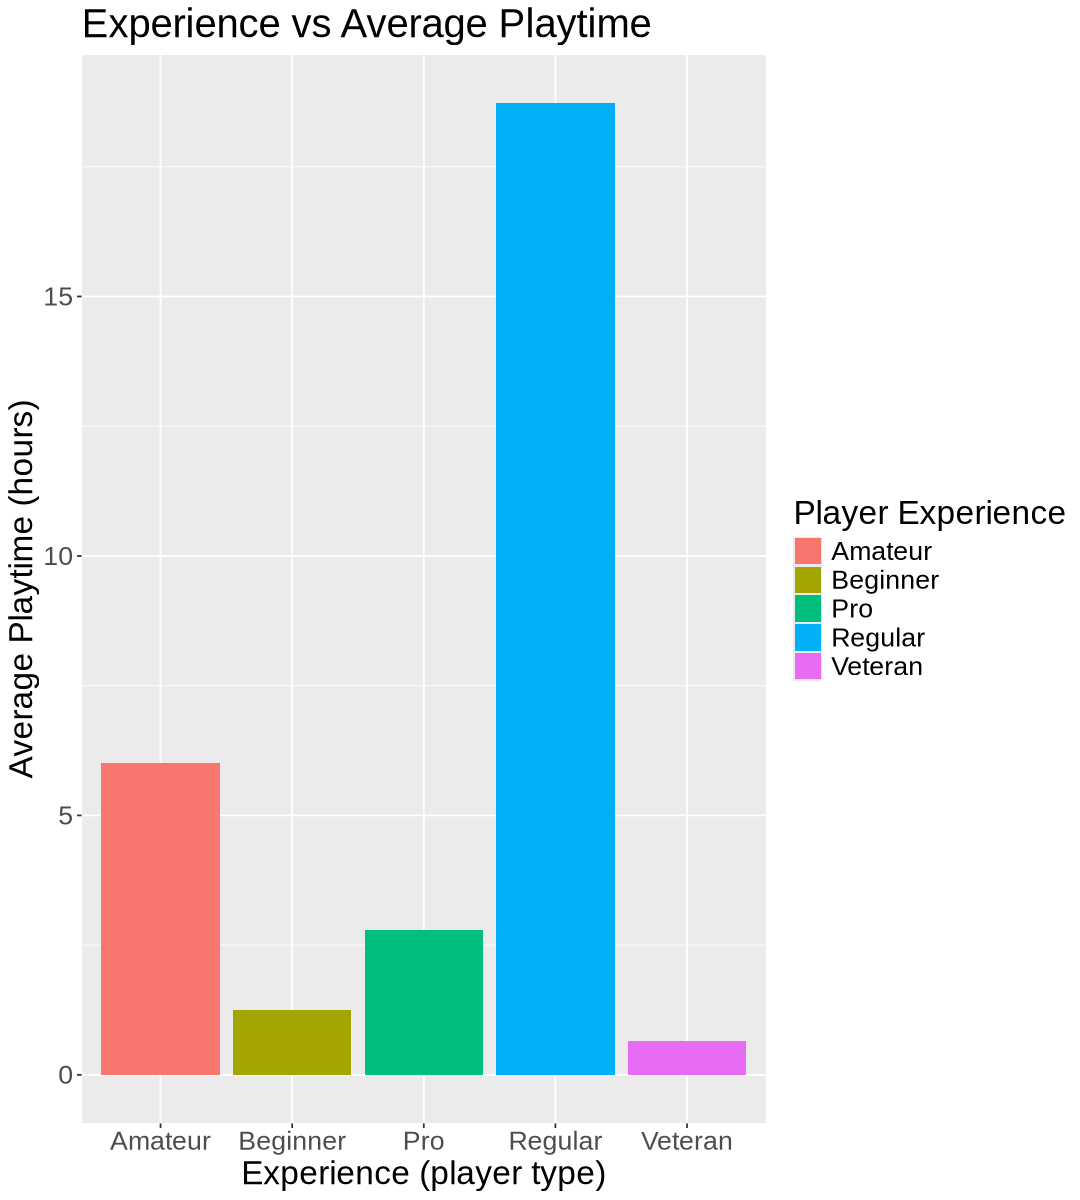

In [20]:
options(repr.plot.width=9,repr.plot.height=10)
# visualizing the distribution of player types in the dataset
player_type_viz <- players_data|>
                    group_by(hashedEmail)|>
                    ggplot(aes(x = experience, fill = experience))+
                    geom_bar()+
                    labs(title="Type of Player Distrubution In dataset",
                         y="Count",
                         x="Player type (experience)",
                        fill="Experience Level")+
                        theme(text=element_text(size=20))


player_type_viz

# visualizing the relationship between player type and hours played
experienceplaytime <- minecraft_data|>
                        group_by(experience)|>
                        summarize(avg_playtime=mean(played_hours,na.rm=TRUE))|>
                        ggplot(aes(x=experience,y=avg_playtime,fill=experience))+
                        geom_bar(stat="identity")+
                        labs(x="Experience (player type)",
                             y="Average Playtime (hours)",
                             title="Experience vs Average Playtime",
                             fill="Player Experience")+
                        theme(text=element_text(size=20))

experienceplaytime


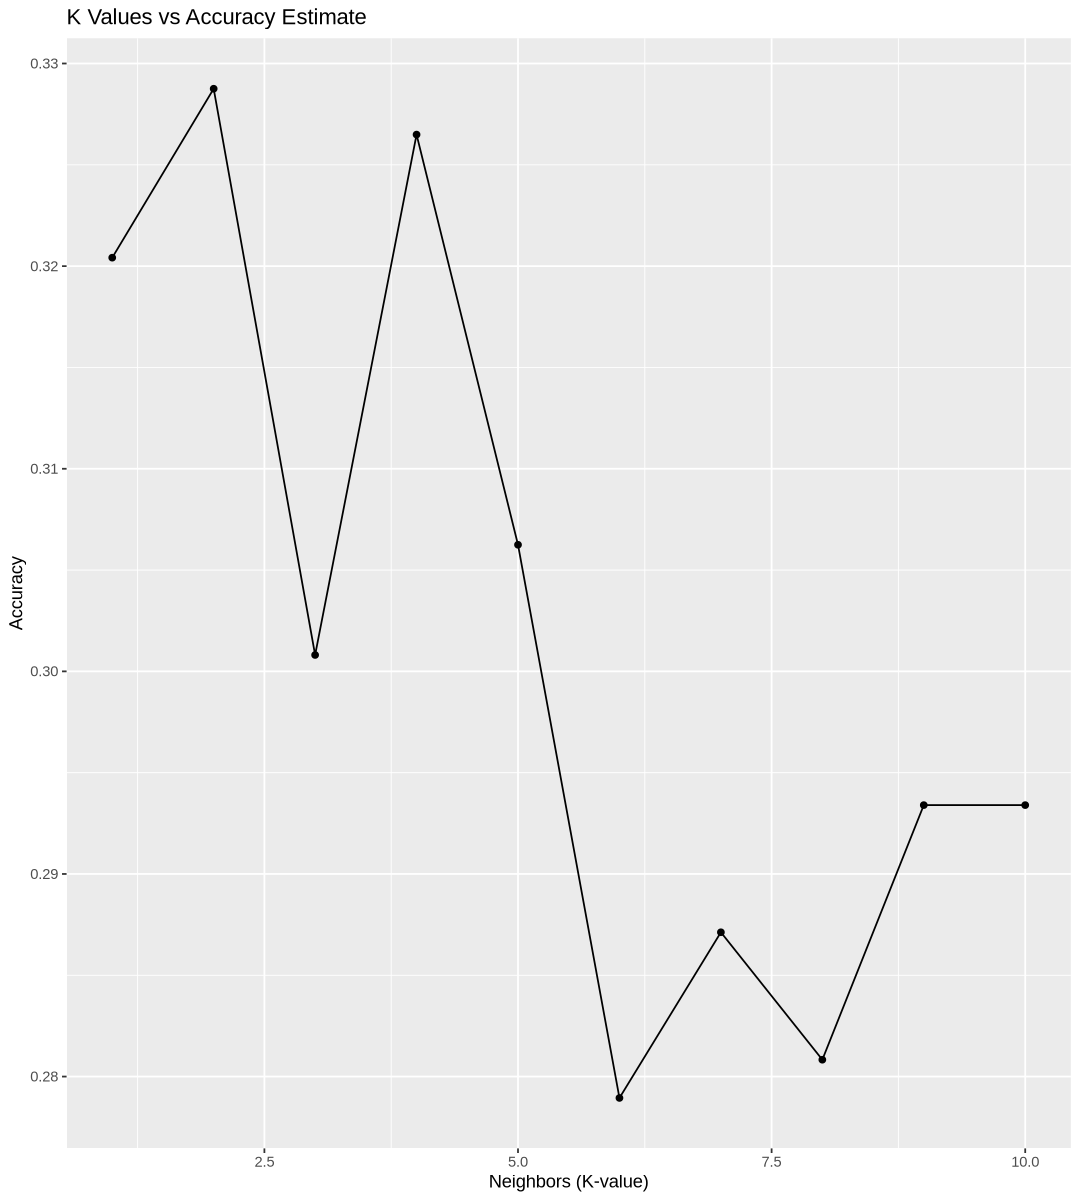

In [24]:

# performing Knn Classification for Data Analysis
set.seed(3456) # Don't change

#changing the subscribe columns into a DBL to be used as a predictor
minecraft_data <- minecraft_data|>
                        mutate(subscribe = as.double(subscribe))




# splitting the data into training and testing
minecraft_split <- initial_split(minecraft_data, prop = 0.8, strata = experience)
minecraft_training <- training(minecraft_split)
minecraft_testing <- testing(minecraft_split)

# creating the recipe
minecraft_recipe <- recipe(experience ~ Age + played_hours+subscribe, data = minecraft_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

# creating knn classification model
minecraft_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                    set_engine("kknn") |>
                    set_mode("classification")

# 5-fold cross validation
minecraft_vfold <- vfold_cv(minecraft_training, v = 5, strata = experience)

# k values tibble for tuning
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

# workflow
knn_results <- workflow() |>
                add_recipe(minecraft_recipe) |>
                add_model(minecraft_spec) |>
                tune_grid(resamples = minecraft_vfold, grid = k_vals) |>
                collect_metrics()


# filtering for accuracy
accuracies <- knn_results |>
                filter(.metric == "accuracy")

# accuracy visualization
accuracy_plot <- accuracies |>
                    ggplot(aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line()+
                    labs(x="Neighbors (K-value)",
                         y="Accuracy",
                         title="K Values vs Accuracy Estimate")
accuracy_plot

In [22]:
#finding the best value for K
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 7

In [41]:
#predicing on the testing data
minecraft_finalspec <- nearest_neighbor(weight_func="rectangular",neighbors=best_k)|>
                        set_engine("kknn")|>
                        set_mode("classification")

minecraft_fit <- workflow()|>
                    add_recipe(minecraft_recipe)|>
                    add_model(minecraft_finalspec)|>
                    fit(minecraft_training)


minecraft_test_predictions <- predict(minecraft_fit,minecraft_testing)|>
                                    bind_cols(minecraft_testing)|>
                                    mutate(experience =as_factor(experience ))

minecraft_test_predictions


minecraft_prediction_true <- minecraft_test_predictions|>
                                filter(.pred_class==experience)

minecraft_prediction_true

.pred_class,experience,subscribe,played_hours,gender,Age
<fct>,<fct>,<dbl>,<dbl>,<chr>,<dbl>
Regular,Pro,1,30.3,Male,9
Veteran,Amateur,0,0.0,Male,21
Amateur,Veteran,1,1.6,Female,23
Beginner,Beginner,1,1.5,Female,25
Beginner,Amateur,1,0.2,Male,22
Veteran,Amateur,0,0.0,Male,22
Amateur,Beginner,1,1.0,Male,17
Amateur,Regular,1,0.6,Female,28
Veteran,Veteran,0,0.1,Male,18


.pred_class,experience,subscribe,played_hours,gender,Age
<fct>,<fct>,<dbl>,<dbl>,<chr>,<dbl>
Beginner,Beginner,1,1.5,Female,25
Veteran,Veteran,0,0.1,Male,18
Amateur,Amateur,1,150.0,Female,16
Amateur,Amateur,0,2.1,Male,24
Veteran,Veteran,0,0.3,Male,22
Amateur,Amateur,0,0.0,Prefer not to say,17


<font size= "5">Discussion:<font>